#### Useful libraries

In [1]:
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import TD3
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

#### Create the environment 

In [2]:


# In your_notebook.ipynb
from env_creator import energy_management_env_creator
from energy_management_env import EnergyManagementEnv
import gym

%run register_env.py

# Register the environment
energy_management_env_creator(SOC_min=0.2, SOC_max=0.8, E=1000, lambda_val=10, data_path='Data_input_v2.csv', initial_SOC=0.5)

# Create the environment
env = gym.make('EnergyManagement-v0')

#### Useful Functions

In [3]:
import time
import warnings
from typing import Optional, Tuple

import numpy as np

from stable_baselines3.common.vec_env.base_vec_env import VecEnv, VecEnvObs, VecEnvStepReturn, VecEnvWrapper


class VecMonitor(VecEnvWrapper):
    """
    A vectorized monitor wrapper for *vectorized* Gym environments,
    it is used to record the episode reward, length, time and other data.

    Some environments like `openai/procgen <https://github.com/openai/procgen>`_
    or `gym3 <https://github.com/openai/gym3>`_ directly initialize the
    vectorized environments, without giving us a chance to use the ``Monitor``
    wrapper. So this class simply does the job of the ``Monitor`` wrapper on
    a vectorized level.

    :param venv: The vectorized environment
    :param filename: the location to save a log file, can be None for no log
    :param info_keywords: extra information to log, from the information return of env.step()
    """

    def __init__(
        self,
        venv: VecEnv,
        filename: Optional[str] = None,
        info_keywords: Tuple[str, ...] = (),
    ):
        # Avoid circular import
        from stable_baselines3.common.monitor import Monitor, ResultsWriter

        # This check is not valid for special `VecEnv`
        # like the ones created by Procgen, that does follow completely
        # the `VecEnv` interface
        try:
            is_wrapped_with_monitor = venv.env_is_wrapped(Monitor)[0]
        except AttributeError:
            is_wrapped_with_monitor = False

        if is_wrapped_with_monitor:
            warnings.warn(
                "The environment is already wrapped with a `Monitor` wrapper"
                "but you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will be"
                "overwritten by the `VecMonitor` ones.",
                UserWarning,
            )

        VecEnvWrapper.__init__(self, venv)
        self.episode_count = 0
        self.t_start = time.time()

        env_id = None
        if hasattr(venv, "spec") and venv.spec is not None:
            env_id = venv.spec.id

        self.results_writer: Optional[ResultsWriter] = None
        if filename:
            self.results_writer = ResultsWriter(
                filename, header={"t_start": self.t_start, "env_id": str(env_id)}, extra_keys=info_keywords
            )

        self.info_keywords = info_keywords
        self.episode_returns = np.zeros(self.num_envs, dtype=np.float32)
        self.episode_lengths = np.zeros(self.num_envs, dtype=np.int32)

    def reset(self) -> VecEnvObs:
        obs = self.venv.reset()
        self.episode_returns = np.zeros(self.num_envs, dtype=np.float32)
        self.episode_lengths = np.zeros(self.num_envs, dtype=np.int32)
        return obs

    def step_wait(self) -> VecEnvStepReturn:
        obs, rewards, dones, infos = self.venv.step_wait()
        self.episode_returns += rewards
        self.episode_lengths += 1
        new_infos = list(infos[:])
        for i in range(len(dones)):
            if dones[i]:
                info = infos[i].copy()
                episode_return = self.episode_returns[i]
                episode_length = self.episode_lengths[i]
                episode_info = {"r": episode_return, "l": episode_length, "t": round(time.time() - self.t_start, 6)}
                for key in self.info_keywords:
                    episode_info[key] = info[key]
                info["episode"] = episode_info
                self.episode_count += 1
                self.episode_returns[i] = 0
                self.episode_lengths[i] = 0
                if self.results_writer:
                    self.results_writer.write_row(episode_info)
                new_infos[i] = info
        return obs, rewards, dones, new_infos

    def close(self) -> None:
        if self.results_writer:
            self.results_writer.close()
        return self.venv.close()

In [4]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [5]:
import matplotlib.pyplot as plt
from stable_baselines3.common.results_plotter import load_results, ts2xy

import seaborn as sns

def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

def plot_results(log_folders, title="Learning Curves"):
    """
    Plot the results for multiple log folders on the same plot using Seaborn.

    :param log_folders: (list of str) List of save locations of the results to plot
    :param title: (str) The title of the plot
    """
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(12, 8))
    max_steps = 0
    all_interpolated_results = []

    for log_folder in log_folders:
        x, y = ts2xy(load_results(log_folder), "timesteps")
        y = moving_average(y, window=1000)
        x = x[len(x) - len(y):]

        max_steps = max(max_steps, x[-1])

        # Interpolation
        common_x = np.linspace(0, x[-1], num=1000)
        interpolated_y = np.interp(common_x, x, y)
        all_interpolated_results.append((common_x, interpolated_y))

    for i, (x, y) in enumerate(all_interpolated_results):
        sns.lineplot(x=x, y=y, label=log_folders[i].split('\\')[-1], linewidth=2)

    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.legend()
    plt.show()

#### Create a file for every model

In [6]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Create log dirs for each model in the current directory
log_dir_ppo = os.path.join(current_dir, "PPO3")
log_dir_dqn = os.path.join(current_dir, "DQN3")
log_dir_ars = os.path.join(current_dir, "ARS3")
log_dir_a2c = os.path.join(current_dir, "A2C3")
log_dir_qrdqn = os.path.join(current_dir, "QR-DQN3")
log_dir_recurrent_ppo = os.path.join(current_dir, "Recurrent_PPO3")
log_dir_trpo = os.path.join(current_dir, "TRPO3")
log_dir = current_dir  # Log directory in the current directory

# Create directories if they don't exist
os.makedirs(log_dir_ppo, exist_ok=True)
os.makedirs(log_dir_dqn, exist_ok=True)
os.makedirs(log_dir_ars, exist_ok=True)
os.makedirs(log_dir_a2c, exist_ok=True)
os.makedirs(log_dir_qrdqn, exist_ok=True)
os.makedirs(log_dir_recurrent_ppo, exist_ok=True)
os.makedirs(log_dir_trpo, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)


##### Test the environment

In [7]:
import numpy as np

# Define a function to inverse transform sine and cosine values
def inverse_transform_sin_cos(sin_val, cos_val):
    angle = np.arctan2(sin_val, cos_val)
    original_value = (angle + 2 * np.pi) % (2 * np.pi)
    return original_value

# Function to invert transform month, day, and hour sine/cosine values
def inverse_transform_state(observation):
    month_sin = observation[3]
    month_cos = observation[4]
    day_sin = observation[5]
    day_cos = observation[6]
    hour_sin = observation[7]
    hour_cos = observation[8]

    original_month = inverse_transform_sin_cos(month_sin, month_cos) * 12 / (2 * np.pi)
    original_day = inverse_transform_sin_cos(day_sin, day_cos) * 31 / (2 * np.pi)
    original_hour = inverse_transform_sin_cos(hour_sin, hour_cos) * 24 / (2 * np.pi)

    return original_month, original_day, original_hour


In [8]:
# Run a simulation loop
observation = env.reset()
L=[]
for t in range(1000):
    L.append(observation[2])
    # Print information before and after taking action
    print(f"Step {t + 1}:")
    
    # Before Action
    print(f"  Before Action: Demand={observation[0]:.2f}, Price={observation[2]:.2f}, SOC={observation[1]:.2f}", end="")
    print(f", Month_sin={observation[3]:.2f}, Month_cos={observation[4]:.2f}, Day_sin={observation[5]:.2f}, Day_cos={observation[6]:.2f}, Hour_sin={observation[7]:.2f}, Hour_cos={observation[8]:.2f}")
    inv_observation = inverse_transform_state(observation)
    print(f"  Month={inv_observation[0]:.2f}, Day={inv_observation[1]:.2f}, Hour={inv_observation[2]:.2f}")

    # Sample an action
    action = env.action_space.sample()
    # Before SOC and Action
    print(f"  |  SOC before action: {observation[1]:.2f}", end=" ")

    # Decode action
    decoded_action = -0.1 if action == 0 else (0 if action == 1 else 0.1)
    print(f" | Action taken: {decoded_action}", end="\n")

    # Take action and get new observation
    observation, reward, done, _ = env.step(action)

    # After SOC and Reward
    print(f"  |  SOC after action: {observation[1]:.2f}")
    print(f"| Scaled Cost: {- np.round(reward, 2)}| Actual Cost: {- np.round(reward * env.reward_scale, 2)}")
    print()

env.close()

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\s

Step 1:
  Before Action: Demand=0.31, Price=-0.43, SOC=0.53, Month_sin=-0.50, Month_cos=-0.87, Day_sin=0.20, Day_cos=0.98, Hour_sin=0.00, Hour_cos=1.00
  Month=7.00, Day=1.00, Hour=0.00
  |  SOC before action: 0.53  | Action taken: 0.1
  |  SOC after action: 0.63
| Scaled Cost: 1.34| Actual Cost: 166.88

Step 2:
  Before Action: Demand=0.26, Price=-0.42, SOC=0.63, Month_sin=-0.50, Month_cos=-0.87, Day_sin=0.20, Day_cos=0.98, Hour_sin=0.26, Hour_cos=0.97
  Month=7.00, Day=1.00, Hour=1.00
  |  SOC before action: 0.63  | Action taken: 0.1
  |  SOC after action: 0.73
| Scaled Cost: 1.19| Actual Cost: 148.45

Step 3:
  Before Action: Demand=0.23, Price=-0.60, SOC=0.73, Month_sin=-0.50, Month_cos=-0.87, Day_sin=0.20, Day_cos=0.98, Hour_sin=0.50, Hour_cos=0.87
  Month=7.00, Day=1.00, Hour=2.00
  |  SOC before action: 0.73  | Action taken: 0.1
  |  SOC after action: 0.80
| Scaled Cost: 0.81| Actual Cost: 101.12

Step 4:
  Before Action: Demand=0.25, Price=-0.65, SOC=0.80, Month_sin=-0.50, Mont

  |  SOC after action: 0.70
| Scaled Cost: 1.4| Actual Cost: 175.47

Step 204:
  Before Action: Demand=0.38, Price=-0.48, SOC=0.70, Month_sin=-0.50, Month_cos=-0.87, Day_sin=0.97, Day_cos=-0.25, Hour_sin=0.26, Hour_cos=-0.97
  Month=7.00, Day=9.00, Hour=11.00
  |  SOC before action: 0.70  | Action taken: -0.1
  |  SOC after action: 0.60
| Scaled Cost: 1.15| Actual Cost: 144.04

Step 205:
  Before Action: Demand=0.38, Price=-0.38, SOC=0.60, Month_sin=-0.50, Month_cos=-0.87, Day_sin=0.97, Day_cos=-0.25, Hour_sin=0.00, Hour_cos=-1.00
  Month=7.00, Day=9.00, Hour=12.00
  |  SOC before action: 0.60  | Action taken: 0.1
  |  SOC after action: 0.70
| Scaled Cost: 1.59| Actual Cost: 198.75

Step 206:
  Before Action: Demand=0.41, Price=-0.21, SOC=0.70, Month_sin=-0.50, Month_cos=-0.87, Day_sin=0.97, Day_cos=-0.25, Hour_sin=-0.26, Hour_cos=-0.97
  Month=7.00, Day=9.00, Hour=13.00
  |  SOC before action: 0.70  | Action taken: -0.1
  |  SOC after action: 0.60
| Scaled Cost: 1.43| Actual Cost: 179

##### PPO

In [9]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from energy_management_env import EnergyManagementEnv

# Register the custom environment (assuming you have already registered it)
env_id = 'EnergyManagement-v0'

# Define a function to create the environment
def make_env():
    return gym.make(env_id)

# Create the vectorized environment with 8 parallel environments using DummyVecEnv
num_envs = 8
vec_env = DummyVecEnv([make_env for _ in range(num_envs)])

# Wrap the vectorized environment with VecNormalize
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=False, clip_obs=10.0)
callback_ppo = SaveOnBestTrainingRewardCallback(check_freq=100, log_dir=log_dir_ppo)
vec_env = VecMonitor(vec_env, log_dir_ppo)

model = PPO("MlpPolicy", vec_env, verbose=1, gamma = 1)
model.learn(total_timesteps=5e6, callback = callback_ppo)
model.save("ppo_energy_management3")

del model  # Remove to demonstrate saving and loading

model = PPO.load("ppo_energy_management3")
print("Training Done")


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable

Using cpu device


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\s

Num timesteps: 6400
Best mean reward: -inf - Last mean reward per episode: -1259.84
Saving new best model to c:\Users\HP\UT\Term I\ECE 381V\Project\Code\RL for Battery Management\PPO3\best_model.zip
Num timesteps: 7200
Best mean reward: -1259.84 - Last mean reward per episode: -1259.84
Num timesteps: 8000
Best mean reward: -1259.84 - Last mean reward per episode: -1259.84
Num timesteps: 8800
Best mean reward: -1259.84 - Last mean reward per episode: -1259.84
Num timesteps: 9600
Best mean reward: -1259.84 - Last mean reward per episode: -1259.84
Num timesteps: 10400
Best mean reward: -1259.84 - Last mean reward per episode: -1259.84
Num timesteps: 11200
Best mean reward: -1259.84 - Last mean reward per episode: -1259.84
Num timesteps: 12000
Best mean reward: -1259.84 - Last mean reward per episode: -1259.95
Num timesteps: 12800
Best mean reward: -1259.84 - Last mean reward per episode: -1259.95
Num timesteps: 13600
Best mean reward: -1259.84 - Last mean reward per episode: -1259.95
Num 

In [ ]:
# Run a simulation loop
observation = env.reset()
L=[]
for t in range(1664):
    # Print information before and after taking action
    print(f"Step {t + 1}:")
    
    # Before Action
    print(f"  Before Action: Demand={observation[0]:.2f}, Price={observation[2]:.2f}, SOC={observation[1]:.2f}", end="")
    print(f", Month_sin={observation[3]:.2f}, Month_cos={observation[4]:.2f}, Day_sin={observation[5]:.2f}, Day_cos={observation[6]:.2f}, Hour_sin={observation[7]:.2f}, Hour_cos={observation[8]:.2f}")
    inv_observation = inverse_transform_state(observation)
    print(f"  Month={inv_observation[0]:.2f}, Day={inv_observation[1]:.2f}, Hour={inv_observation[2]:.2f}")

    # Sample an action
    action, _states = model.predict(observation)
    # Before SOC and Action
    print(f"  |  SOC before action: {observation[1]:.2f}", end=" ")

    
    # Decode action
    decoded_action = -0.1 if action == 0 else (0 if action == 1 else 0.1)
    L.append(decoded_action)
    print(f" | Action taken: {decoded_action}", end="\n")

    # Take action and get new observation
    observation, reward, done, _ = env.step(action)

    # After SOC and Reward
    print(f"  |  SOC after action: {observation[1]:.2f}")
    print(f"| Scaled Cost: {- np.round(reward, 2)}| Actual Cost: {- np.round(reward * env.reward_scale, 2)}")
    print()

env.close()

Step 1:
  Before Action: Demand=0.31, Price=-0.43, SOC=0.55, Month_sin=-0.50, Month_cos=-0.87, Day_sin=0.20, Day_cos=0.98, Hour_sin=0.00, Hour_cos=1.00
  Month=7.00, Day=1.00, Hour=0.00
  |  SOC before action: 0.55  | Action taken: -0.1
  |  SOC after action: 0.45
| Scaled Cost: 0.97| Actual Cost: 121.34

Step 2:
  Before Action: Demand=0.26, Price=-0.42, SOC=0.45, Month_sin=-0.50, Month_cos=-0.87, Day_sin=0.20, Day_cos=0.98, Hour_sin=0.26, Hour_cos=0.97
  Month=7.00, Day=1.00, Hour=1.00
  |  SOC before action: 0.45  | Action taken: -0.1
  |  SOC after action: 0.35
| Scaled Cost: 0.82| Actual Cost: 102.55

Step 3:
  Before Action: Demand=0.23, Price=-0.60, SOC=0.35, Month_sin=-0.50, Month_cos=-0.87, Day_sin=0.20, Day_cos=0.98, Hour_sin=0.50, Hour_cos=0.87
  Month=7.00, Day=1.00, Hour=2.00
  |  SOC before action: 0.35  | Action taken: -0.1
  |  SOC after action: 0.25
| Scaled Cost: 0.65| Actual Cost: 80.67

Step 4:
  Before Action: Demand=0.25, Price=-0.65, SOC=0.25, Month_sin=-0.50, Mo

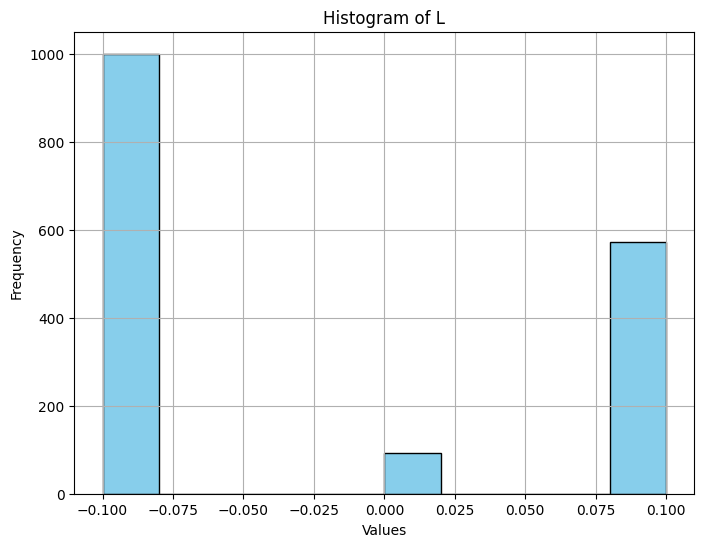

In [ ]:
import matplotlib.pyplot as plt

# Create a histogram for the list 'L'
plt.figure(figsize=(8, 6))
plt.hist(L, bins=10, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of L')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


#### DQN

#### TRPO

#### Plotting

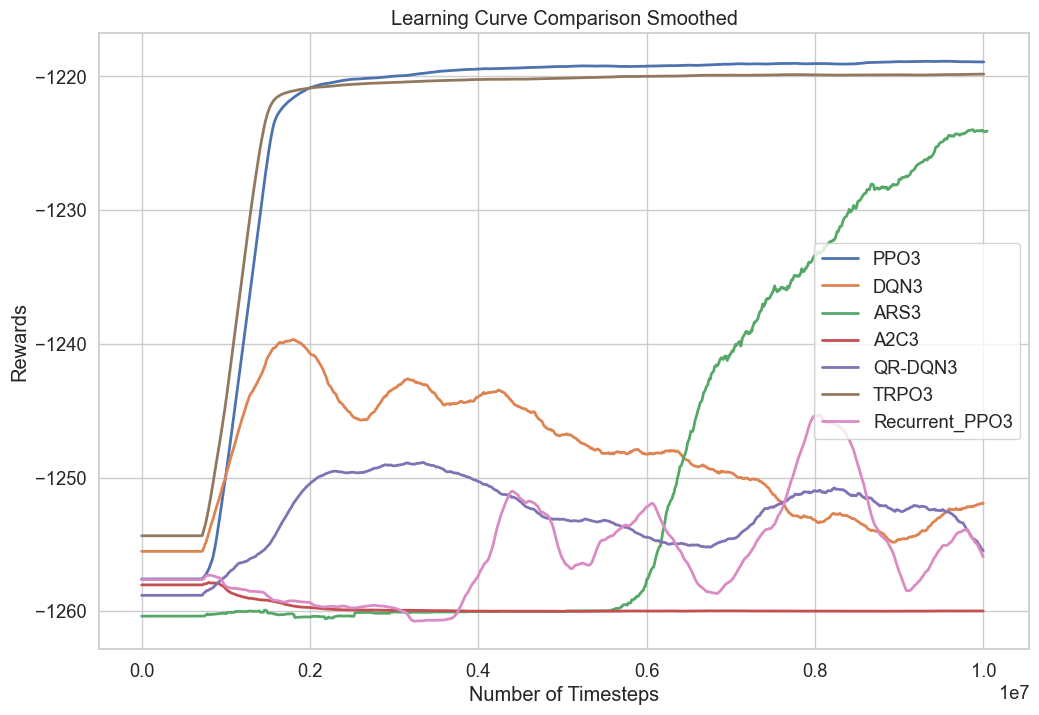

In [ ]:
# Example usage:
log_dirs = [log_dir_ppo, log_dir_dqn, log_dir_ars, log_dir_a2c, log_dir_qrdqn, log_dir_trpo, log_dir_recurrent_ppo]
plot_results(log_dirs, title="Learning Curve Comparison")

In [1]:
# Example usage:
log_dirs = [log_dir_ppo]
plot_results(log_dirs, title="Learning Curve Comparison")

NameError: name 'log_dir_ppo' is not defined